# Importar dependencias

In [1]:
# Importación de librerías estándar de Python y PyTorch
import os.path as osp
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías de PyTorch y PyTorch Geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module, CrossEntropyLoss
from torch.optim import Adam

# Módulos de PyTorch Geometric
from torch_geometric.nn import MLP, GCNConv, GATConv, GIN, GCN, SAGEConv
from torch_geometric.data import InMemoryDataset, download_url

# Utilidad para mostrar la arquitectura del modelo
from torchsummary import summary

# Métricas de evaluación
from sklearn.metrics import confusion_matrix, f1_score

# Cargar el dataset

In [2]:
torch.cuda.is_available()

True

In [3]:
class TournamentDataset(InMemoryDataset):

    TORUNAMENT_URL = 'https://drive.upm.es/s/mnsESjBucKUKsEg/download'

    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['tournament.pt']

    @property
    def processed_file_names(self):
        return ['tournament.pt']

    @property
    def num_classes(self):
        return 3

    @property
    def num_features(self):
        return 500

    def download(self):
        download_url(self.TORUNAMENT_URL, self.raw_dir, filename='tournament.pt')

    def process(self):
        data_list = [torch.load(osp.join(self.raw_dir, 'tournament.pt'))]

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])

    def create_test_json(self, model, file_path, device="cpu"):
        data = self[0]

        model = model.to(device)
        data = data.to(device)

        model.eval()
        out = model(data.x, data.edge_index)
        y_pred = out[data.test_mask].argmax(dim=1)
        nid = data.nid[data.test_mask]

        pred = {
            'nid': nid.detach().cpu().numpy().tolist(),
            'y': y_pred.detach().cpu().numpy().tolist()
        }

        with open(file_path, 'w') as f:
            json.dump(pred, f)


In [4]:
dataset = TournamentDataset("tournament")
data = dataset[0]

In [5]:
print(data.train_mask.sum())
print(data.val_mask.sum())
print(data.test_mask.sum())


tensor(15970)
tensor(1775)
tensor(1972)


# Modelos

In [6]:
f1_by_model = {}

def train_model(model, model_name, dataset):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    optm_func = CrossEntropyLoss()

    data = dataset.to(device)

    model.train()
    for epoch in range(1000):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = optm_func(out[data.train_mask], data.y[data.train_mask].argmax(dim=1))
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss {loss.item()}")

    model.eval()
    out = model(data.x, data.edge_index)

    print("\n\nMODEL VALIDATION:\n")
    y_pred = out.argmax(dim=1)[data.val_mask].detach().cpu()
    y = data.y.argmax(dim=1)[data.val_mask].detach().cpu()

    f1_val = f1_score(y, y_pred, average='micro')
    print(f"Validation F1 score: {f1_val}")
    # sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues');

    print("\n\nMODEL TEST:\n")
    y_pred = out.argmax(dim=1)[data.test_mask].detach().cpu()
    y_pred = y_pred.numpy()
    y = pd.read_csv('test_labels.csv')['y'].values
    y = torch.tensor(y).cpu().numpy()
    f1_test = f1_score(y, y_pred, average='micro')
    print(f"Test F1 score: {f1_test}")

    f1_by_model[model_name] = [f1_val, f1_test]

## Baseline - MLP

In [7]:
model = MLP(
    in_channels=dataset.num_node_features,
    out_channels=dataset.num_classes,
    num_layers=2,
    hidden_channels=32
)
summary(model, (data.x, data.edge_index));

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 32]                  16,032
├─ModuleList: 1                          []                        --
|    └─BatchNorm: 2-2                    [-1, 32]                  --
|    |    └─BatchNorm1d: 3-1             [-1, 32]                  64
├─ReLU: 1-1                              [-1, 32]                  --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-3                       [-1, 3]                   99
Total params: 16,195
Trainable params: 16,195
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 38.28
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 38.35


In [8]:
train_model(model, "MLP", data)

Epoch 0: Loss 1.3579387664794922
Epoch 10: Loss 0.4842308759689331
Epoch 20: Loss 0.329582542181015
Epoch 30: Loss 0.2640852928161621
Epoch 40: Loss 0.22606459259986877
Epoch 50: Loss 0.1959904134273529
Epoch 60: Loss 0.16866092383861542
Epoch 70: Loss 0.141808420419693
Epoch 80: Loss 0.11581441015005112
Epoch 90: Loss 0.0941544696688652
Epoch 100: Loss 0.07386821508407593
Epoch 110: Loss 0.05560578033328056
Epoch 120: Loss 0.0432312898337841
Epoch 130: Loss 0.039951059967279434
Epoch 140: Loss 0.028671186417341232
Epoch 150: Loss 0.02293195202946663
Epoch 160: Loss 0.6288860440254211
Epoch 170: Loss 0.16710802912712097
Epoch 180: Loss 0.10295815020799637
Epoch 190: Loss 0.06876469403505325
Epoch 200: Loss 0.05146314576268196
Epoch 210: Loss 0.038320280611515045
Epoch 220: Loss 0.030399026349186897
Epoch 230: Loss 0.024757705628871918
Epoch 240: Loss 0.020814210176467896
Epoch 250: Loss 0.017962131649255753
Epoch 260: Loss 0.015867440029978752
Epoch 270: Loss 0.014280589297413826
Epoch

## Aproximación I - GCNMLP

In [9]:
class GCNMLP(Module):

    def __init__(self, num_features, num_classes, hidden_channels=32, n_layers=2):
        super(GCNMLP, self).__init__()
        self.gcn = GCN(
            in_channels=num_features,
            hidden_channels=hidden_channels,
            num_layers=n_layers,
            out_channels=hidden_channels,
        )
        self.cls = MLP(
            in_channels=hidden_channels,
            hidden_channels=hidden_channels,
            out_channels=num_classes,
            num_layers=2,
            dropout=0.5
        )

    def reset_parameters(self):
        self.gcn.reset_parameters()
        self.cls.reset_parameters()

    def forward(self, x, edge_index):
        x = self.gcn(x, edge_index)
        x = self.cls(x)
        return x

In [10]:
model = GCNMLP(
    dataset.num_node_features,
    dataset.num_classes,
    hidden_channels=48,
    n_layers=5
)

model.reset_parameters()

summary(model, (data.x, data.edge_index));

Layer (type:depth-idx)                        Output Shape              Param #
├─GCN: 1-1                                    [-1, 48]                  --
|    └─ModuleList: 2                          []                        --
|    |    └─GCNConv: 3-1                      [-1, 48]                  24,048
|    └─ModuleList: 2                          []                        --
|    |    └─Identity: 3-2                     [-1, 48]                  --
|    └─ReLU: 2-1                              [-1, 48]                  --
|    └─Dropout: 2-2                           [-1, 48]                  --
|    └─ModuleList: 2                          []                        --
|    |    └─GCNConv: 3-3                      [-1, 48]                  2,352
|    └─ModuleList: 2                          []                        --
|    |    └─Identity: 3-4                     [-1, 48]                  --
|    └─ReLU: 2-3                              [-1, 48]                  --
|    └─Dropou

In [11]:
train_model(model, "GCNMLP", data)

Epoch 0: Loss 1.2144372463226318
Epoch 10: Loss 0.48101678490638733
Epoch 20: Loss 0.42964664101600647
Epoch 30: Loss 0.4043819010257721
Epoch 40: Loss 0.3879830241203308
Epoch 50: Loss 0.3747926652431488
Epoch 60: Loss 0.3647252917289734
Epoch 70: Loss 0.35730183124542236
Epoch 80: Loss 0.3443533480167389
Epoch 90: Loss 0.33203431963920593
Epoch 100: Loss 0.34967562556266785
Epoch 110: Loss 0.3281095027923584
Epoch 120: Loss 0.3158959150314331
Epoch 130: Loss 0.30947256088256836
Epoch 140: Loss 0.2939211130142212
Epoch 150: Loss 0.2596166133880615
Epoch 160: Loss 0.3367003798484802
Epoch 170: Loss 0.30592796206474304
Epoch 180: Loss 0.254535973072052
Epoch 190: Loss 0.22869090735912323
Epoch 200: Loss 0.19490349292755127
Epoch 210: Loss 0.17414900660514832
Epoch 220: Loss 0.16637283563613892
Epoch 230: Loss 0.1402612030506134
Epoch 240: Loss 0.32643166184425354
Epoch 250: Loss 0.25878989696502686
Epoch 260: Loss 0.21289464831352234
Epoch 270: Loss 0.1712133139371872
Epoch 280: Loss 0.

## Aproximación II - GINMLP

In [12]:
class GINMLP(Module):

    def __init__(self, num_features, num_classes, hidden_channels=32, n_layers=2):
        super(GINMLP, self).__init__()
        self.gcn = GIN(
            in_channels=num_features,
            hidden_channels=hidden_channels,
            num_layers=n_layers,
            out_channels=hidden_channels,
            dropout=0.5,
            act="relu",
            jk="cat"
        )
        self.cls = MLP(
            in_channels=hidden_channels,
            hidden_channels=hidden_channels,
            out_channels=num_classes,
            num_layers=2,
            dropout=0.5
        )

    def reset_parameters(self):
        self.gcn.reset_parameters()
        self.cls.reset_parameters()

    def forward(self, x, edge_index):
        x = self.gcn(x, edge_index)
        x = self.cls(x)
        return x

In [13]:
model = GINMLP(
    dataset.num_node_features,
    dataset.num_classes,
    hidden_channels=32,
    n_layers=3
)

model.reset_parameters()

summary(model, (data.x, data.edge_index));

Layer (type:depth-idx)                   Output Shape              Param #
├─GIN: 1-1                               [-1, 32]                  --
|    └─ModuleList: 2                     []                        --
|    |    └─GINConv: 3-1                 [-1, 32]                  17,088
|    └─ReLU: 2-1                         [-1, 32]                  --
|    └─ModuleList: 2                     []                        --
|    |    └─Identity: 3-2                [-1, 32]                  --
|    └─ReLU: 2-2                         [-1, 32]                  --
|    └─Dropout: 2-3                      [-1, 32]                  --
|    └─ModuleList: 2                     []                        --
|    |    └─GINConv: 3-3                 [-1, 32]                  2,112
|    └─ReLU: 2-4                         [-1, 32]                  --
|    └─ModuleList: 2                     []                        --
|    |    └─Identity: 3-4                [-1, 32]                  --
|    └─R

In [14]:
train_model(model, "GINMLP", data)

Epoch 0: Loss 1.1192479133605957
Epoch 10: Loss 0.9757670760154724
Epoch 20: Loss 0.827665388584137
Epoch 30: Loss 0.7656267881393433
Epoch 40: Loss 0.7120621204376221
Epoch 50: Loss 0.6663424372673035
Epoch 60: Loss 0.5981178879737854
Epoch 70: Loss 0.5055944323539734
Epoch 80: Loss 0.42547187209129333
Epoch 90: Loss 0.3813863694667816
Epoch 100: Loss 0.34702062606811523
Epoch 110: Loss 0.3180527091026306
Epoch 120: Loss 0.31045636534690857
Epoch 130: Loss 0.27108994126319885
Epoch 140: Loss 0.24622303247451782
Epoch 150: Loss 0.263576477766037
Epoch 160: Loss 0.23214522004127502
Epoch 170: Loss 0.20200297236442566
Epoch 180: Loss 0.1946658194065094
Epoch 190: Loss 0.19588474929332733
Epoch 200: Loss 0.1778413951396942
Epoch 210: Loss 0.20484904944896698
Epoch 220: Loss 0.1744355410337448
Epoch 230: Loss 0.15467755496501923
Epoch 240: Loss 0.1456914097070694
Epoch 250: Loss 0.1368647813796997
Epoch 260: Loss 0.12953510880470276
Epoch 270: Loss 0.13619747757911682
Epoch 280: Loss 0.134

## Aproximación III - Convolucional

In [15]:
class Convolucional(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(Convolucional, self).__init__()

        self.dropout_rate = dropout_rate

        # Capas de GNN
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        self.gat = GATConv(hidden_channels, hidden_channels, heads=8, concat=False)
        self.gcn3 = GCNConv(hidden_channels, hidden_channels)

        # Capas densas (más profundas)
        self.fc1 = nn.Linear(hidden_channels, hidden_channels // 2)
        self.fc2 = nn.Linear(hidden_channels // 2, hidden_channels // 4)
        self.fc3 = nn.Linear(hidden_channels // 4, hidden_channels // 8)
        self.fc4 = nn.Linear(hidden_channels // 8, out_channels)

    def forward(self, x, edge_index):
        # Capas GCN y GAT
        x = F.relu(self.gcn1(x, edge_index))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = F.relu(self.gcn2(x, edge_index))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = F.relu(self.gat(x, edge_index))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = F.relu(self.gcn3(x, edge_index))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        # Capas densas finales
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = F.relu(self.fc3(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = self.fc4(x)  # Capa final sin activación, log-softmax al final

        return x.log_softmax(dim=-1)


In [16]:
model = Convolucional(
    dataset.num_node_features,
    64,
    dataset.num_classes
)

summary(model, (data.x, data.edge_index));

Layer (type:depth-idx)                   Output Shape              Param #
├─GCNConv: 1-1                           [-1, 64]                  --
|    └─Linear: 2-1                       [-1, 64]                  32,000
|    └─SumAggregation: 2-2               [-1, 64]                  --
├─GCNConv: 1-2                           [-1, 64]                  --
|    └─Linear: 2-3                       [-1, 64]                  4,096
|    └─SumAggregation: 2-4               [-1, 64]                  --
├─GATConv: 1-3                           [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 512]                 32,768
|    └─SumAggregation: 2-6               [-1, 8, 64]               --
├─GCNConv: 1-4                           [-1, 64]                  --
|    └─Linear: 2-7                       [-1, 64]                  4,096
|    └─SumAggregation: 2-8               [-1, 64]                  --
├─Linear: 1-5                            [-1, 32]                  2,08

In [17]:
train_model(model, "Convolucional", data)

Epoch 0: Loss 1.1379339694976807
Epoch 10: Loss 1.0825361013412476
Epoch 20: Loss 0.9564608335494995
Epoch 30: Loss 0.8567831516265869
Epoch 40: Loss 0.8158344626426697
Epoch 50: Loss 0.7831470966339111
Epoch 60: Loss 0.7588058710098267
Epoch 70: Loss 0.7376648187637329
Epoch 80: Loss 0.716252326965332
Epoch 90: Loss 0.6751753091812134
Epoch 100: Loss 0.6456558704376221
Epoch 110: Loss 0.632782518863678
Epoch 120: Loss 0.6329590678215027
Epoch 130: Loss 0.6253604888916016
Epoch 140: Loss 0.7711410522460938
Epoch 150: Loss 0.6885467767715454
Epoch 160: Loss 0.6568063497543335
Epoch 170: Loss 0.6294886469841003
Epoch 180: Loss 0.61507648229599
Epoch 190: Loss 0.6041634678840637
Epoch 200: Loss 0.5858628749847412
Epoch 210: Loss 0.602570652961731
Epoch 220: Loss 0.6255032420158386
Epoch 230: Loss 0.574266791343689
Epoch 240: Loss 0.5583333373069763
Epoch 250: Loss 0.5630202889442444
Epoch 260: Loss 0.6980453133583069
Epoch 270: Loss 0.6198546886444092
Epoch 280: Loss 0.5863429307937622
Ep

In [18]:
class Convolucional_Softmax(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Convolucional_Softmax, self).__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gat = GATConv(hidden_channels, hidden_channels, heads=3, concat=False)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # Primera capa GCN
        x = F.relu(self.gcn1(x, edge_index))
        # Atención con GAT
        x = F.relu(self.gat(x, edge_index))
        # Segunda capa GCN
        x = F.relu(self.gcn2(x, edge_index))
        # Clasificación final
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [19]:
model = Convolucional_Softmax(
    dataset.num_node_features,
    1024,
    dataset.num_classes
)

summary(model, (data.x, data.edge_index));

Layer (type:depth-idx)                   Output Shape              Param #
├─GCNConv: 1-1                           [-1, 1024]                --
|    └─Linear: 2-1                       [-1, 1024]                512,000
|    └─SumAggregation: 2-2               [-1, 1024]                --
├─GATConv: 1-2                           [-1, 1024]                --
|    └─Linear: 2-3                       [-1, 3072]                3,145,728
|    └─SumAggregation: 2-4               [-1, 3, 1024]             --
├─GCNConv: 1-3                           [-1, 1024]                --
|    └─Linear: 2-5                       [-1, 1024]                1,048,576
|    └─SumAggregation: 2-6               [-1, 1024]                --
├─Linear: 1-4                            [-1, 3]                   3,075
Total params: 4,709,379
Trainable params: 4,709,379
Non-trainable params: 0
Total mult-adds (M): 9.42
Input size (MB): 38.28
Forward/backward pass size (MB): 0.04
Params size (MB): 17.96
Estimated Total 

In [20]:
train_model(model, "Convolucional Softmax", data)

Epoch 0: Loss 1.0963342189788818
Epoch 10: Loss 1.0370769500732422
Epoch 20: Loss 0.5303160548210144
Epoch 30: Loss 0.3833645284175873
Epoch 40: Loss 0.3225124180316925
Epoch 50: Loss 0.2930957078933716
Epoch 60: Loss 0.2646530568599701
Epoch 70: Loss 0.2682093679904938
Epoch 80: Loss 0.24866603314876556
Epoch 90: Loss 0.2603994607925415
Epoch 100: Loss 0.20964859426021576
Epoch 110: Loss 0.21328772604465485
Epoch 120: Loss 0.1959710717201233
Epoch 130: Loss 0.16626381874084473
Epoch 140: Loss 0.3544591963291168
Epoch 150: Loss 0.22841808199882507
Epoch 160: Loss 0.17901961505413055
Epoch 170: Loss 0.1616029292345047
Epoch 180: Loss 0.1390870362520218
Epoch 190: Loss 0.23041704297065735
Epoch 200: Loss 0.15507656335830688
Epoch 210: Loss 0.1329539269208908
Epoch 220: Loss 0.11308877170085907
Epoch 230: Loss 0.33990639448165894
Epoch 240: Loss 0.19866010546684265
Epoch 250: Loss 0.15989623963832855
Epoch 260: Loss 0.13364683091640472
Epoch 270: Loss 0.1159772202372551
Epoch 280: Loss 0.

In [21]:
class Convolucional_Droput(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(Convolucional_Droput, self).__init__()

        # Capas de GNN
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gat = GATConv(hidden_channels, hidden_channels, heads=3, concat=False)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)

        # Capas densas finales
        self.fc1 = nn.Linear(hidden_channels, hidden_channels // 2)
        self.fc2 = nn.Linear(hidden_channels // 2, out_channels)

        # Dropout rate
        self.dropout_rate = dropout_rate

    def forward(self, x, edge_index):
        # Primera capa GCN
        x = F.relu(self.gcn1(x, edge_index))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        # Atención con GAT
        x = F.relu(self.gat(x, edge_index))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        # Segunda capa GCN
        x = F.relu(self.gcn2(x, edge_index))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        # Capas densas finales
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)


In [22]:
model = Convolucional_Droput(
    dataset.num_node_features,
    1024,
    dataset.num_classes
)

summary(model, (data.x, data.edge_index));

Layer (type:depth-idx)                   Output Shape              Param #
├─GCNConv: 1-1                           [-1, 1024]                --
|    └─Linear: 2-1                       [-1, 1024]                512,000
|    └─SumAggregation: 2-2               [-1, 1024]                --
├─GATConv: 1-2                           [-1, 1024]                --
|    └─Linear: 2-3                       [-1, 3072]                3,145,728
|    └─SumAggregation: 2-4               [-1, 3, 1024]             --
├─GCNConv: 1-3                           [-1, 1024]                --
|    └─Linear: 2-5                       [-1, 1024]                1,048,576
|    └─SumAggregation: 2-6               [-1, 1024]                --
├─Linear: 1-4                            [-1, 512]                 524,800
├─Linear: 1-5                            [-1, 3]                   1,539
Total params: 5,232,643
Trainable params: 5,232,643
Non-trainable params: 0
Total mult-adds (M): 9.94
Input size (MB): 38.28
For

In [23]:
train_model(model, "Convolucional Dropout", data)

Epoch 0: Loss 1.1075527667999268
Epoch 10: Loss 1.0618896484375
Epoch 20: Loss 0.9239147901535034
Epoch 30: Loss 0.767058253288269
Epoch 40: Loss 0.7035830616950989
Epoch 50: Loss 0.6331450343132019
Epoch 60: Loss 0.4169538915157318
Epoch 70: Loss 0.3492259681224823
Epoch 80: Loss 0.30021026730537415
Epoch 90: Loss 0.2820627987384796
Epoch 100: Loss 0.2704602777957916
Epoch 110: Loss 0.24472366273403168
Epoch 120: Loss 0.246921569108963
Epoch 130: Loss 0.23847393691539764
Epoch 140: Loss 0.2238328605890274
Epoch 150: Loss 0.21691839396953583
Epoch 160: Loss 0.20535914599895477
Epoch 170: Loss 0.22637556493282318
Epoch 180: Loss 0.205704003572464
Epoch 190: Loss 0.19206950068473816
Epoch 200: Loss 0.20894479751586914
Epoch 210: Loss 0.20064549148082733
Epoch 220: Loss 0.1920214146375656
Epoch 230: Loss 0.20008499920368195
Epoch 240: Loss 0.18029513955116272
Epoch 250: Loss 0.1744617223739624
Epoch 260: Loss 0.2192462682723999
Epoch 270: Loss 0.2219155877828598
Epoch 280: Loss 0.18529962

## Aproximación IV - Graph Sage

In [29]:
class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GraphSAGEModel, self).__init__()

        # Capas convolucionales
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)

        # Capas densas
        self.fc1 = torch.nn.Linear(hidden_channels, hidden_channels // 2)
        self.fc2 = torch.nn.Linear(hidden_channels // 2, hidden_channels // 4)
        self.fc3 = torch.nn.Linear(hidden_channels // 4, out_channels)

        # Dropout rate
        self.dropout_rate = dropout_rate

    def forward(self, x, edge_index):
        # Capas convolucionales
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)

        # Capas densas
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = F.relu(self.fc3(x))

        return x


In [30]:
model = GraphSAGEModel(
    dataset.num_node_features,
    64,
    dataset.num_classes
)

summary(model, (data.x, data.edge_index));

Layer (type:depth-idx)                   Output Shape              Param #
├─SAGEConv: 1-1                          [-1, 64]                  --
|    └─MeanAggregation: 2-1              [-1, 500]                 --
|    └─Linear: 2-2                       [-1, 64]                  32,064
|    └─Linear: 2-3                       [-1, 64]                  32,000
├─SAGEConv: 1-2                          [-1, 64]                  --
|    └─MeanAggregation: 2-4              [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 64]                  4,160
|    └─Linear: 2-6                       [-1, 64]                  4,096
├─SAGEConv: 1-3                          [-1, 64]                  --
|    └─MeanAggregation: 2-7              [-1, 64]                  --
|    └─Linear: 2-8                       [-1, 64]                  4,160
|    └─Linear: 2-9                       [-1, 64]                  4,096
├─SAGEConv: 1-4                          [-1, 64]                

In [31]:
train_model(model, "Graph SAGE", data)

Epoch 0: Loss 1.085205316543579
Epoch 10: Loss 0.9382565021514893
Epoch 20: Loss 0.7641995549201965
Epoch 30: Loss 0.5673186779022217
Epoch 40: Loss 0.43662214279174805
Epoch 50: Loss 0.34925469756126404
Epoch 60: Loss 0.32298359274864197
Epoch 70: Loss 0.265854150056839
Epoch 80: Loss 0.20395880937576294
Epoch 90: Loss 0.19447343051433563
Epoch 100: Loss 0.2540947496891022
Epoch 110: Loss 0.18621952831745148
Epoch 120: Loss 0.14230160415172577
Epoch 130: Loss 0.11209769546985626
Epoch 140: Loss 0.09838292747735977
Epoch 150: Loss 0.0897815003991127
Epoch 160: Loss 0.3152233064174652
Epoch 170: Loss 0.44540533423423767
Epoch 180: Loss 0.3675389289855957
Epoch 190: Loss 0.2773006856441498
Epoch 200: Loss 0.19345135986804962
Epoch 210: Loss 0.1979335993528366
Epoch 220: Loss 0.23118546605110168
Epoch 230: Loss 0.14259515702724457
Epoch 240: Loss 0.11866258084774017
Epoch 250: Loss 0.10445050150156021
Epoch 260: Loss 0.09693131595849991
Epoch 270: Loss 0.09560416638851166
Epoch 280: Loss 

# Comparación entre modelos

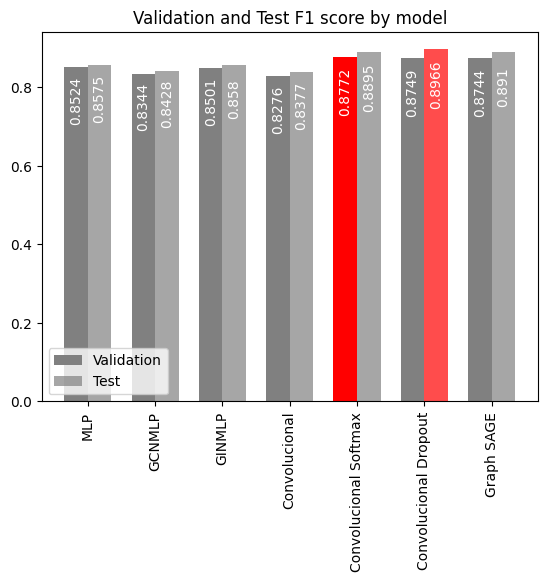

In [32]:
# Separate validation and test scores
val_scores = [scores[0] for scores in f1_by_model.values()]
test_scores = [scores[1] for scores in f1_by_model.values()]

# Define colors for the bars
colors_val = ['grey' if f1 != max(val_scores) else 'red' for f1 in val_scores]
colors_test = ['grey' if f1 != max(test_scores) else 'red' for f1 in test_scores]

# Create subplots
fig, ax = plt.subplots()

# Define bar width and positions
bar_width = 0.35
index = np.arange(len(f1_by_model))

# Plot validation scores
bars_val = ax.bar(index, val_scores, bar_width, color=colors_val, label='Validation')

# Plot test scores
bars_test = ax.bar(index + bar_width, test_scores, bar_width, color=colors_test, label='Test', alpha=0.7)

# Add value labels inside each bar
for bar in bars_val + bars_test:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval * 0.9, round(yval, 4), ha='center', va='center', rotation='vertical', color='white')

# Rotate x-axis labels for better readability
plt.xticks(index + bar_width / 2, f1_by_model.keys(), rotation=90)

# Add title and legend
plt.title("Validation and Test F1 score by model")
plt.legend()

# Show plot
plt.show()


# Generar solución para el torneo

In [33]:
model = Convolucional_Droput(
    dataset.num_node_features,
    1024,
    dataset.num_classes
)

train_model(model, "Convolucional Dropout", data)

dataset.create_test_json(model, 'pred_labels.json', device='cuda')

Epoch 0: Loss 1.1063209772109985
Epoch 10: Loss 1.0844943523406982
Epoch 20: Loss 1.035891056060791
Epoch 30: Loss 1.0347788333892822
Epoch 40: Loss 0.7790254354476929
Epoch 50: Loss 0.7175074815750122
Epoch 60: Loss 0.7230209708213806
Epoch 70: Loss 0.5873377323150635
Epoch 80: Loss 0.43800845742225647
Epoch 90: Loss 0.35876402258872986
Epoch 100: Loss 0.35935670137405396
Epoch 110: Loss 0.31475433707237244
Epoch 120: Loss 0.30180543661117554
Epoch 130: Loss 0.29872146248817444
Epoch 140: Loss 0.2779402732849121
Epoch 150: Loss 0.3096025884151459
Epoch 160: Loss 0.27280193567276
Epoch 170: Loss 0.2569926381111145
Epoch 180: Loss 0.24561570584774017
Epoch 190: Loss 0.264024943113327
Epoch 200: Loss 0.24509891867637634
Epoch 210: Loss 0.22429855167865753
Epoch 220: Loss 0.38868293166160583
Epoch 230: Loss 0.2430698722600937
Epoch 240: Loss 0.2224734127521515
Epoch 250: Loss 0.22249281406402588
Epoch 260: Loss 0.2123962789773941
Epoch 270: Loss 0.2006840854883194
Epoch 280: Loss 0.257782